<a href="https://colab.research.google.com/github/Jarcos09/Tareas/blob/main/BDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente :** Verónica Sandra Guzmán de Valle

### 📊 **Proyecto | Base de Datos de Big Data**

#### 📅 **04 de mayo de 2025**
### 👥 Equipo 29

* 🧑‍💻 **A01795941 :** Juan Carlos Pérez Nava
* 🧑‍💻 **A01016093 :** Oscar Enrique García García
* 🧑‍💻 **A01795164 :** Oscar Andrés Ponce Parra



In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('proyectos/librerias'))
if module_path not in sys.path:
    sys.path.append(module_path)
from graficas import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub



In [ ]:
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print("Path to dataset files:", path)

Path to dataset files: /home/jarcos/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13


In [ ]:
spark = SparkSession.builder.master("local[*]").appName("CargarCSV").config("spark.driver.memory", "40g").config("spark.executor.memory", "20g").getOrCreate()
df_spark = spark.read.option("header", True).option("inferSchema", True).csv(path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 12:49:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Clasificación de los datos

La clasificación de los datos es el proceso de agrupar y organizar la información según sus características y propiedades. Esto permite un análisis más eficiente y una detección más clara de patrones y tendencias dentro de los datos.

In [ ]:
columnas_numericas = ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)' ,'Temperature(F)',
                      'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
                      'Precipitation(in)'
                      ]

columnas_categoricas_num = ['Severity']


columnas_categoricas = ['Source', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode',
                        'Country', 'Timezone', 'Airport_Code', 'Wind_Direction','Weather_Condition'
                        ]

columnas_binarios = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
                     'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
                     'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'
                     ]

columnas_fecha = ['Start_Time', 'End_Time', 'Weather_Timestamp']



**Obtención de las estadísticas descriptivas de las características numéricas.**

La función `summary()` incluye, de forma predeterminada, las siguientes métricas estadísticas:

* `count`: El número de valores no nulos.
* `mean`: La media.
* `stddev`: La desviación estándar.
* `min`: El valor mínimo.
* `max`: El valor máximo.
* `25%`: El primer cuartil (percentil 25).
* `50%`: La mediana (segundo cuartil o percentil 50).
* `75%`: El tercer cuartil (percentil 75).

Estas estadísticas descriptivas son fundamentales para analizar el dominio de cada variable, identificar el rango de valores válidos y comprender su comportamiento en el conjunto de datos.



In [ ]:
df_spark.select(columnas_numericas).summary().show()

25/05/04 12:49:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+--------------------+
|summary|         Start_Lat|         Start_Lng|          End_Lat|           End_Lng|      Distance(mi)|    Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|  Wind_Speed(mph)|   Precipitation(in)|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+--------------------+
|  count|           7728394|           7728394|          4325632|           4325632|           7728394|           7564541|          5729375|           7554250|           7587715|          7551296|          7157161|             5524808|
|   mean| 36.20119454946952|-94.70254538794683|36.261828

In [ ]:
rango_IQR = calcular_IQR(df_spark,columnas_numericas)
rango_IQR

,IQR,Límite Inf.,Límite Sup.
Columna,,,
Start_Lat,6.737238,23.225459,50.174411
Start_Lng,36.850633,-172.508772,-25.106241
End_Lat,6.704169,23.379656,50.196332
End_Lng,37.496485,-174.026617,-24.040678
Distance(mi),0.461000,-0.691500,1.152500
Temperature(F),27.000000,8.500000,116.500000
Wind_Chill(F),32.000000,-5.000000,123.000000
Humidity(%),36.000000,-6.000000,138.000000
Pressure(in),0.670000,28.355000,31.035000


**Obtención de las estadísticas descriptivas de las características categoricas numéricas.**

In [ ]:
total_rows = df_spark.count()

freq = df_spark.groupBy("Severity").agg(
    F.count("*").alias("Frecuencia"),
    F.round((F.count("*") / total_rows) * 100, 2).alias("Porcentaje(%)")
).orderBy("Severity", ascending=True)

freq = freq.withColumn("Frecuencia", F.format_number(F.col("Frecuencia"), 0))

freq.show()


+--------+----------+-------------+
|Severity|Frecuencia|Porcentaje(%)|
+--------+----------+-------------+
|       1|    67,366|         0.87|
|       2| 6,156,981|        79.67|
|       3| 1,299,337|        16.81|
|       4|   204,710|         2.65|
+--------+----------+-------------+



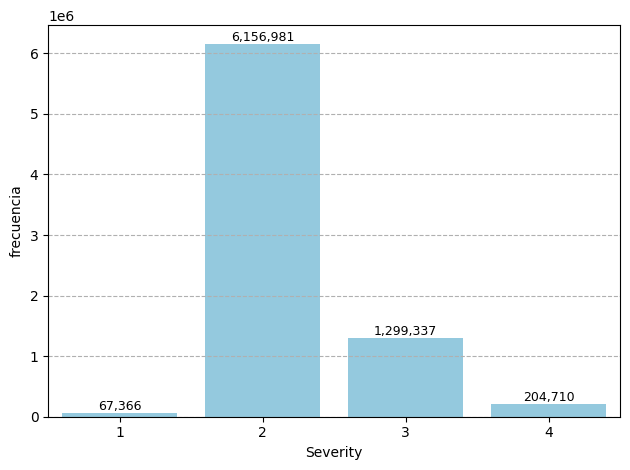

In [ ]:
barras_categorica(df_spark,'Severity')

**Obtención de las estadísticas descriptivas de las características categóricas**

In [ ]:
cat_num = df_spark.agg(*[F.countDistinct(F.col(c)).alias(c) for c in columnas_categoricas]).toPandas().T
cat_num.columns = ['Valores únicos']
cat_num.sort_values(by='Valores únicos', ascending=False)

,Valores únicos
Description,3761578
Zipcode,825094
Street,336306
City,13678
Airport_Code,2045
County,1871
Weather_Condition,144
State,49
Wind_Direction,24
Timezone,4


In [ ]:
frecuencias_cat = obtener_frecuencia(df_spark, columnas_categoricas)
frecuencias_cat

,Valor Más Frecuente,Frecuencia,Porcentaje
Columna,,,
Source,Source1,4325632,55.97
Description,A crash has occurred causing no to minimum del...,9593,0.12
Street,I-95 N,78430,1.01
City,Miami,186917,2.42
County,Los Angeles,526851,6.82
State,CA,1741433,22.53
Zipcode,91761,11247,0.15
Country,US,7728394,100.00
Timezone,US/Eastern,3580167,46.32


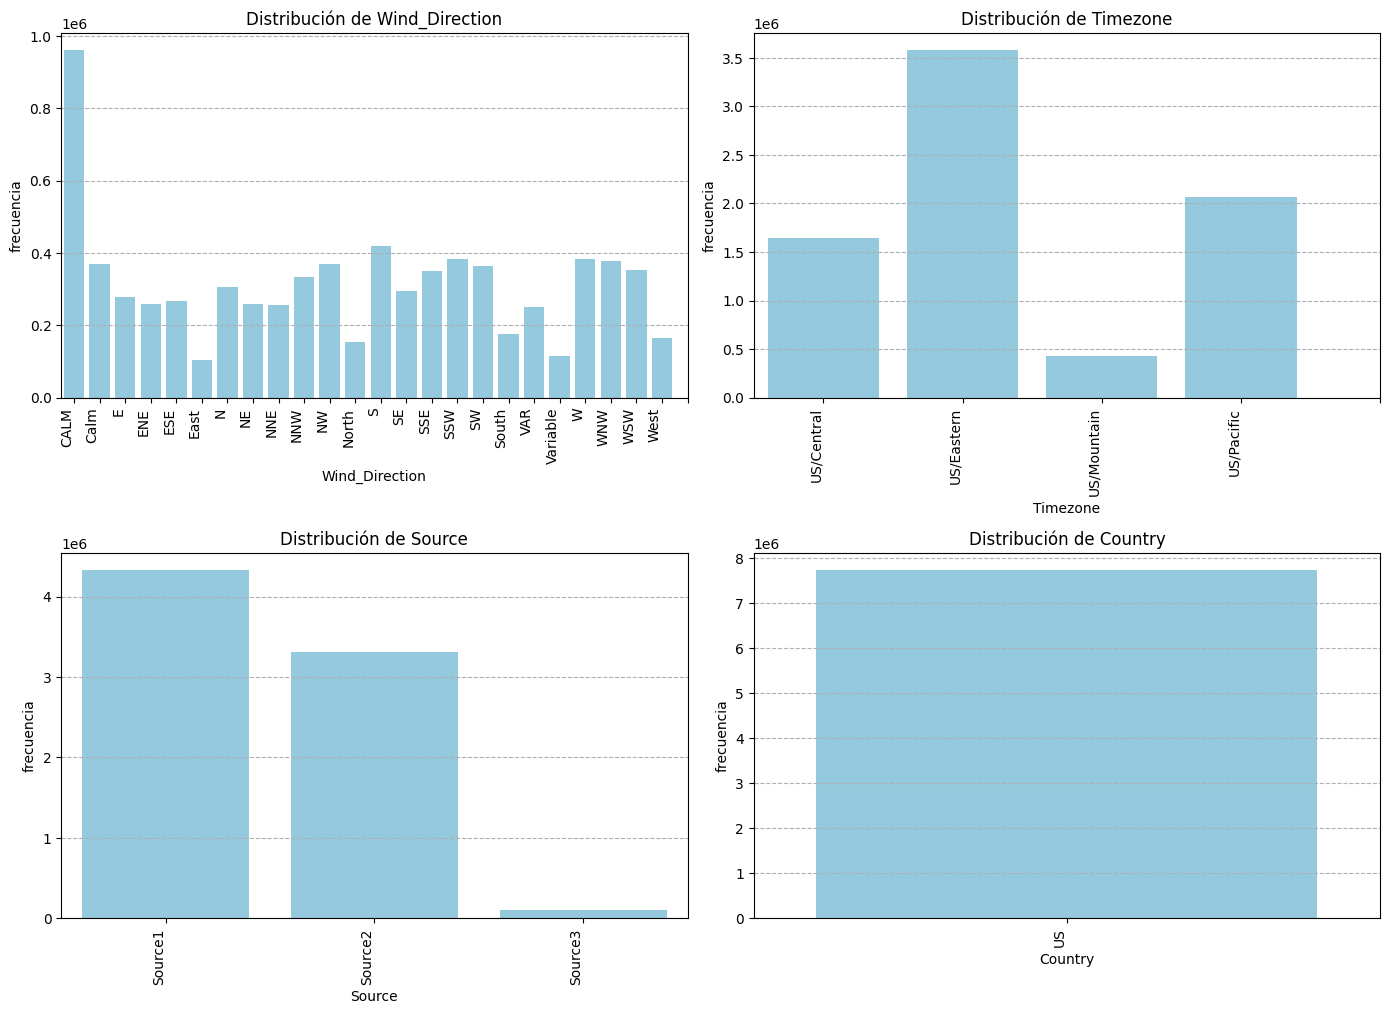

In [ ]:
categoricas_analisis = ['Wind_Direction','Timezone','Source','Country']
barras_cat_num(df_spark, categoricas_analisis)

**Obtención de las estadísticas descriptivas de las características binarias**

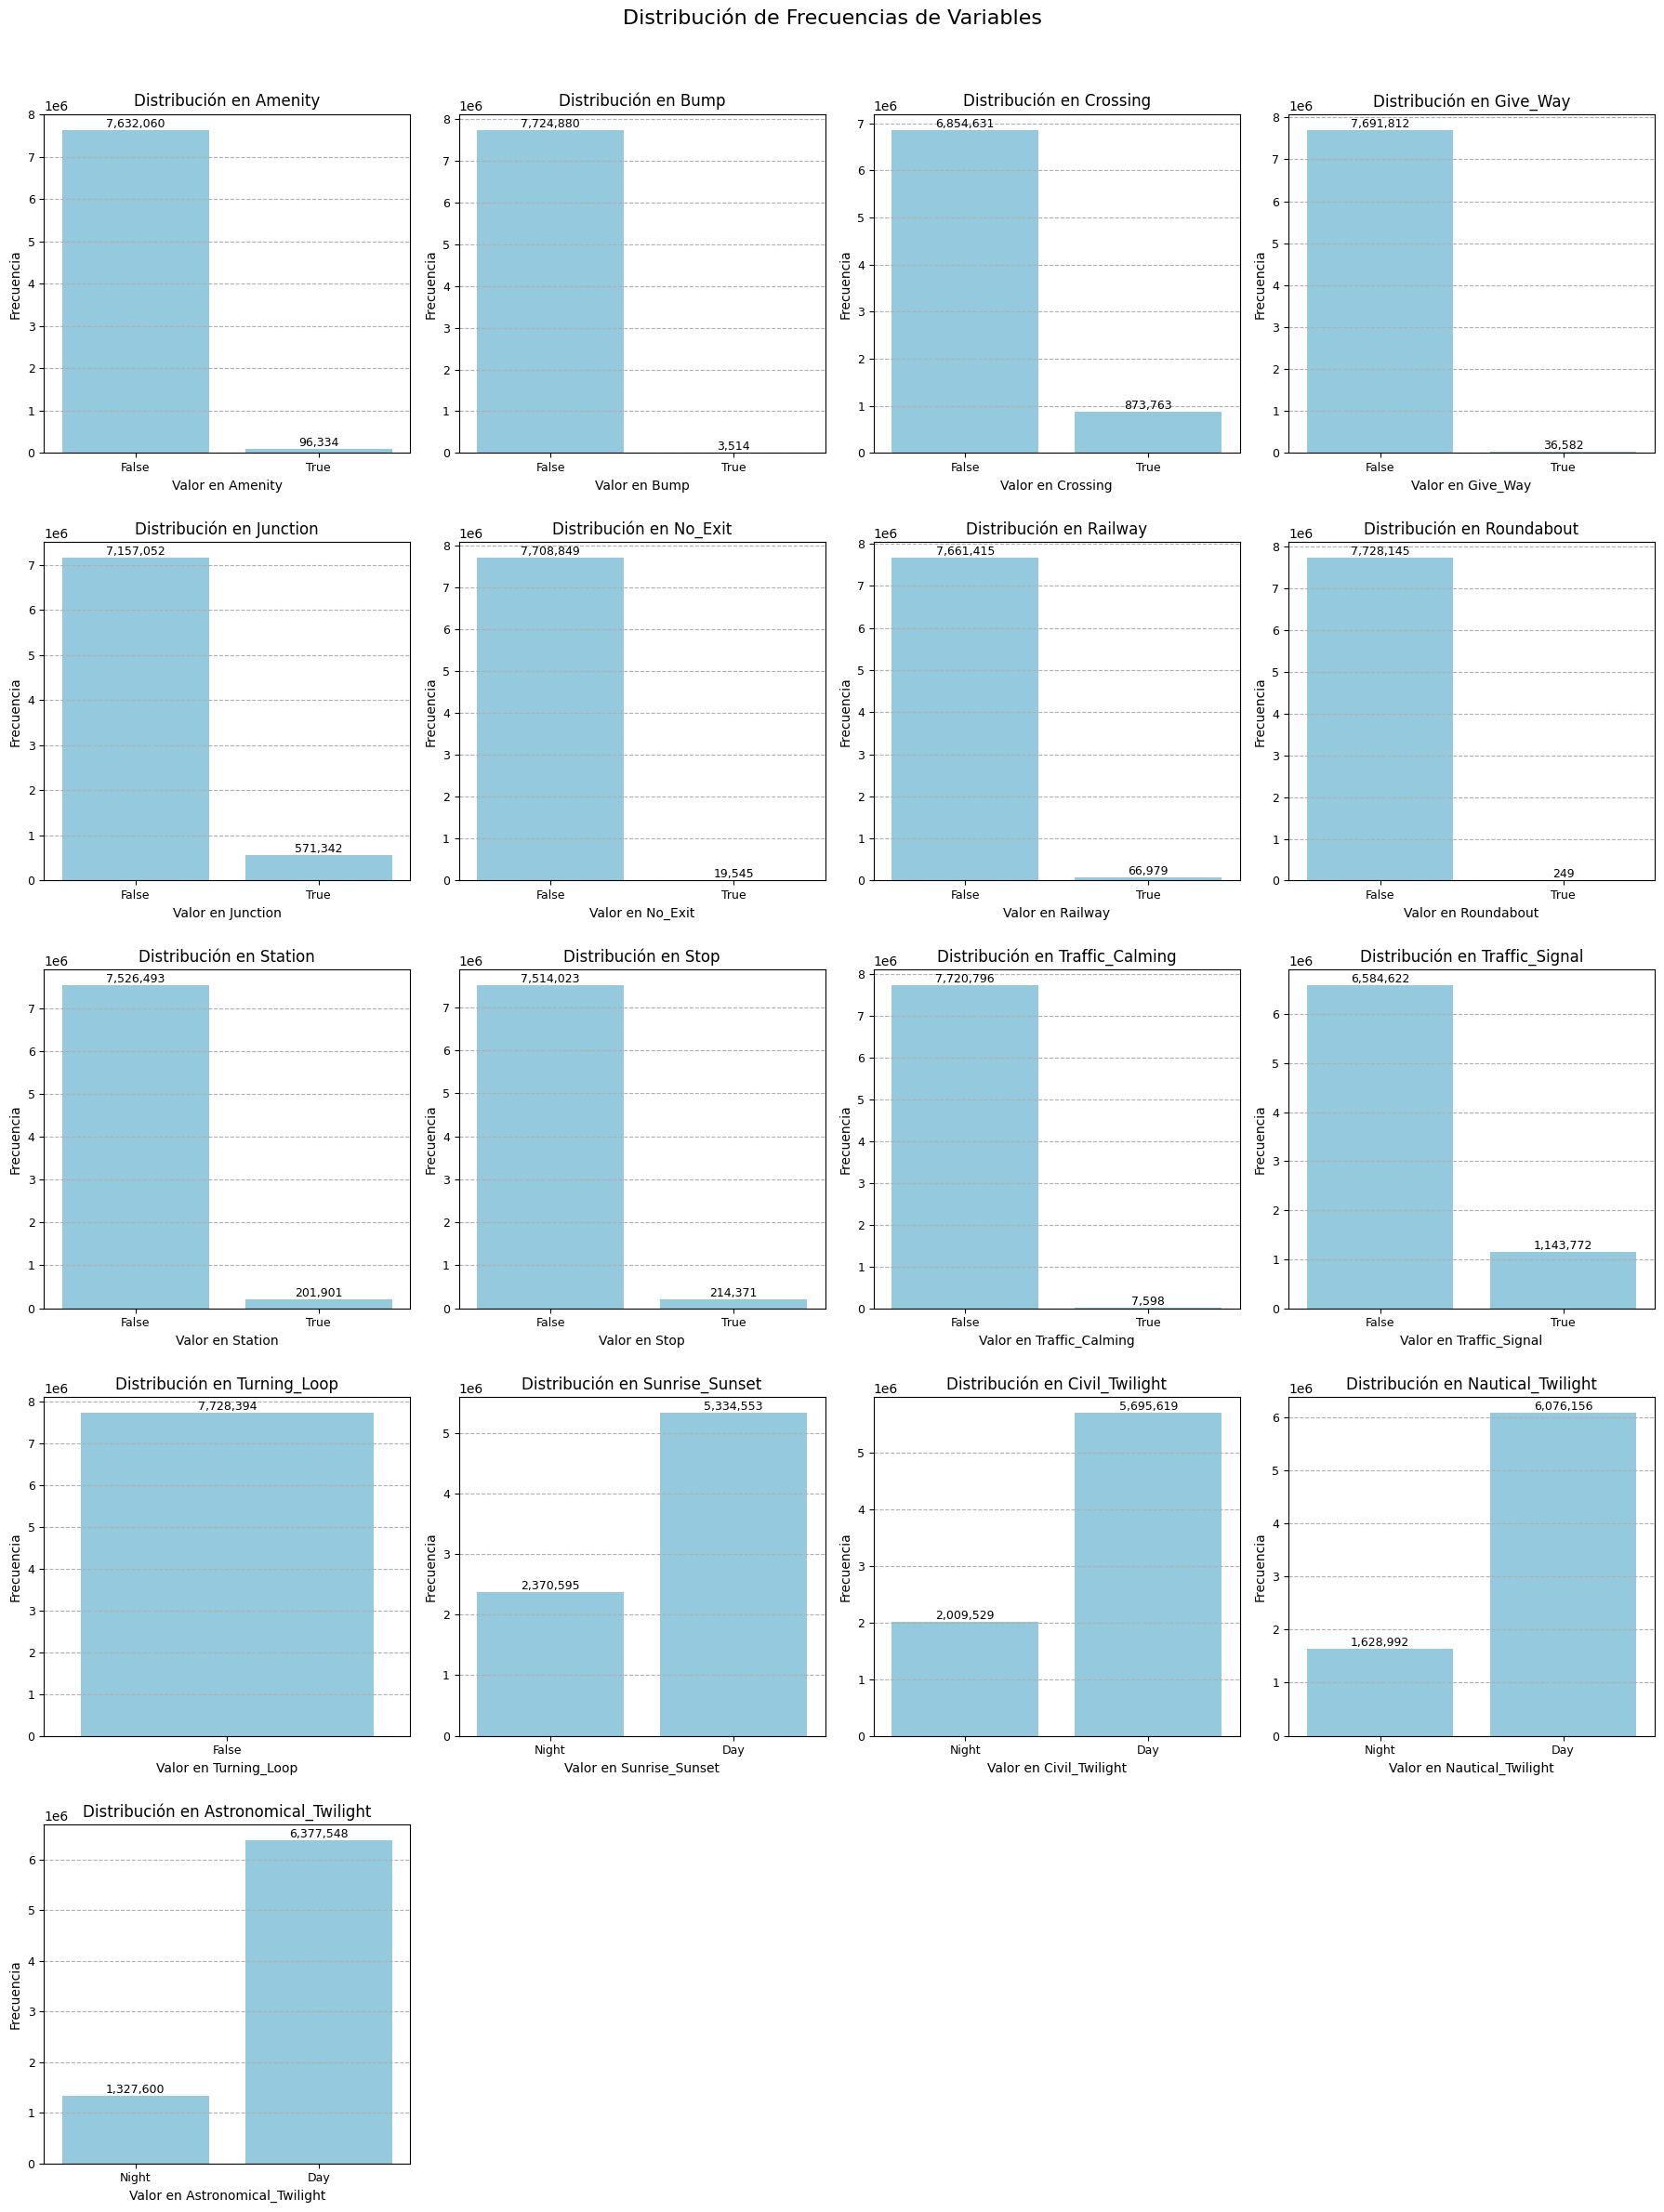

In [ ]:
frecuencias_binarias(df_spark, columnas_binarios)

# Particionamiento

El particionamiento del conjunto de datos se basa en las condiciones climáticas y la severidad del accidente, dividiéndolo en múltiples subconjuntos según combinaciones específicas de estas características.

In [ ]:
total = df_spark.count()

combinaciones_top = df_spark.groupBy("Weather_Condition", "Severity") \
    .agg(F.count("*").alias("Frecuencia")) \
    .withColumn("Proporción", F.col("Frecuencia") / total) \
    .orderBy(F.col("Proporción").desc())

combinaciones_top = combinaciones_top.withColumn("Frecuencia", F.format_number(F.col("Frecuencia"), 0))  \
    .withColumn("Proporción", F.format_number((F.col("Proporción")*100), 3))

combinaciones_top.show(10, truncate=False)

+-----------------+--------+----------+----------+
|Weather_Condition|Severity|Frecuencia|Proporción|
+-----------------+--------+----------+----------+
|Fair             |2       |2,226,576 |28.810    |
|Mostly Cloudy    |2       |792,735   |10.257    |
|Cloudy           |2       |692,929   |8.966     |
|Partly Cloudy    |2       |548,760   |7.101     |
|Clear            |2       |536,971   |6.948     |
|Light Rain       |2       |270,162   |3.496     |
|Overcast         |2       |248,938   |3.221     |
|Clear            |3       |244,956   |3.170     |
|Fair             |3       |240,084   |3.107     |
|Mostly Cloudy    |3       |189,229   |2.448     |
+-----------------+--------+----------+----------+
only showing top 10 rows



#Creando la partición

Se seleccionan  las columnas clave que se emplearán en el análisis de datos, garantizando un tratamiento focalizado y eficiente de la información relevante para posteriores procesos de transformación y exploración.

In [ ]:
columnas_clave = [
    "ID", "Weather_Condition", "Severity","Start_Time", "End_Time", "City", "State",
    "Temperature(F)", "Humidity(%)", "Visibility(mi)"
]

Para crear la particion, se utilizan las siguientes funciones:
* `write.mode("overwrite")` - Especifica que el DataFrame se debe guardar sobrescribiendo cualquier dato previo que ya exista en el destino.

* `partitionBy("Weather_Condition", "Severity")` - Indica que los datos se deben distribuir en particiones basadas en los valores de las columnas "Weather_Condition" y "Severity". Este particionamiento resulta muy útil para consultas que filtren por estas columnas, ya que Spark puede leer únicamente las particiones relevantes sin tener que cargar todo el dataset.

* `parquet("us_accidents_partitioned")` - Finalmente, se especifica el formato de almacenamiento, en este caso Parquet, que es un formato columnar optimizado para consultas analíticas y manejo de grandes volúmenes de datos.


In [ ]:
df_particionada = df_spark.select(columnas_clave)
df_particionada.write.mode("overwrite").partitionBy("Weather_Condition","Severity").parquet("us_accidents_partitioned")

Se definen reglas de particionamiento con el objetivo de verificar que la partición se haya generado correctamente y que cumpla con los criterios esperados en el proceso.


In [ ]:
reglas_particionamiento = [
    {"Weather_Condition": "Fair", "Severity": 2},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 2},
    {"Weather_Condition": "Cloudy", "Severity": 2},
    {"Weather_Condition": "Partly Cloudy", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 2},
    {"Weather_Condition": "Light Rain", "Severity": 2},
    {"Weather_Condition": "Overcast", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 3},
    {"Weather_Condition": "Fair", "Severity": 3},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 3},
]

Se obtiene el número de registros en cada partición según las reglas especificadas previamente, con el objetivo de verificar que la cantidad de registros coincida con la generada a partir del conjunto completo de datos.


In [ ]:
for i, regla in enumerate(reglas_particionamiento, start=1):
    condicion_clima = regla["Weather_Condition"]
    severidad = regla["Severity"]

    df_filtrado = df_particionada.filter(
        (F.col("Weather_Condition") == condicion_clima) &
        (F.col("Severity") == severidad)
    )

    print(f"Partición P_{i:02d}: Weather_Condition = '\033[32m\033[1m{condicion_clima}\033[0m', Severity = \033[32m\033[1m{severidad}\033[0m → Registros: \033[32m\033[1m{df_filtrado.count():,}\033[0m")

Partición P_01: Weather_Condition = 'Fair', Severity = 2 → Registros: 2,226,576


Partición P_02: Weather_Condition = 'Mostly Cloudy', Severity = 2 → Registros: 792,735


Partición P_03: Weather_Condition = 'Cloudy', Severity = 2 → Registros: 692,929


Partición P_04: Weather_Condition = 'Partly Cloudy', Severity = 2 → Registros: 548,760


Partición P_05: Weather_Condition = 'Clear', Severity = 2 → Registros: 536,971


Partición P_06: Weather_Condition = 'Light Rain', Severity = 2 → Registros: 270,162


Partición P_07: Weather_Condition = 'Overcast', Severity = 2 → Registros: 248,938


Partición P_08: Weather_Condition = 'Clear', Severity = 3 → Registros: 244,956


Partición P_09: Weather_Condition = 'Fair', Severity = 3 → Registros: 240,084


Partición P_10: Weather_Condition = 'Mostly Cloudy', Severity = 3 → Registros: 189,229


Se lleva a cabo un muestreo de los datos con el objetivo de verificar los campos clave definidos para el análisis, según lo especificado en el proceso de particionamiento.

In [ ]:
# Submuestra P_01 – Fair & Severity 2
df_P1 = df_particionada.filter(
    (F.col("Weather_Condition") == "Fair") &
    (F.col("Severity") == 2)
).select(columnas_clave).limit(100)

df_P1.show(5)

+-------+-----------------+--------+-------------------+-------------------+---------------+-----+--------------+-----------+--------------+
|     ID|Weather_Condition|Severity|         Start_Time|           End_Time|           City|State|Temperature(F)|Humidity(%)|Visibility(mi)|
+-------+-----------------+--------+-------------------+-------------------+---------------+-----+--------------+-----------+--------------+
|A-42864|             Fair|       2|2016-06-21 10:38:47|2016-06-21 11:18:00|    Simi Valley|   CA|          87.0|       35.0|          10.0|
|A-42971|             Fair|       2|2016-06-21 14:11:33|2016-06-21 15:11:33|       Valencia|   CA|          94.0|       31.0|          10.0|
|A-43017|             Fair|       2|2016-06-21 16:28:36|2016-06-21 17:13:36| Canyon Country|   CA|          85.0|       44.0|          10.0|
|A-43018|             Fair|       2|2016-06-21 16:28:03|2016-06-21 17:13:03| Canyon Country|   CA|          85.0|       44.0|          10.0|
|A-43021|    

In [ ]:
# Submuestra P_02 – Mostly Cloudy & Severity 2
df_P2 = df_particionada.filter(
    (F.col("Weather_Condition") == "Mostly Cloudy") &
    (F.col("Severity") == 2)
).select(columnas_clave).limit(100)

df_P2.show(5, truncate=False)

+----+-----------------+--------+-------------------+-------------------+------+-----+--------------+-----------+--------------+
|ID  |Weather_Condition|Severity|Start_Time         |End_Time           |City  |State|Temperature(F)|Humidity(%)|Visibility(mi)|
+----+-----------------+--------+-------------------+-------------------+------+-----+--------------+-----------+--------------+
|A-5 |Mostly Cloudy    |2       |2016-02-08 07:39:07|2016-02-08 08:09:07|Dayton|OH   |36.0          |89.0       |6.0           |
|A-9 |Mostly Cloudy    |2       |2016-02-08 08:00:40|2016-02-08 08:30:40|Dayton|OH   |33.3          |99.0       |5.0           |
|A-14|Mostly Cloudy    |2       |2016-02-08 08:37:07|2016-02-08 09:07:07|Dayton|OH   |36.0          |89.0       |10.0          |
|A-17|Mostly Cloudy    |2       |2016-02-08 08:53:17|2016-02-08 09:23:17|Dayton|OH   |35.6          |99.0       |7.0           |
|A-18|Mostly Cloudy    |2       |2016-02-08 09:24:37|2016-02-08 09:54:37|Dayton|OH   |36.0       

In [ ]:
# Submuestra P_03 – Cloudy & Severity 2
df_P3 = df_particionada.filter(
    (F.col("Weather_Condition") == "Cloudy") &
    (F.col("Severity") == 2)
).select(columnas_clave).limit(100)

df_P3.show(5, truncate=False)

+-------+-----------------+--------+-------------------+-------------------+---------------+-----+--------------+-----------+--------------+
|ID     |Weather_Condition|Severity|Start_Time         |End_Time           |City           |State|Temperature(F)|Humidity(%)|Visibility(mi)|
+-------+-----------------+--------+-------------------+-------------------+---------------+-----+--------------+-----------+--------------+
|A-364  |Cloudy           |2       |2016-02-24 07:18:41|2016-02-24 08:03:41|Fraziers Bottom|WV   |49.0          |100.0      |10.0          |
|A-44263|Cloudy           |2       |2016-06-25 05:14:09|2016-06-25 05:59:09|Santa Clarita  |CA   |63.0          |90.0       |5.0           |
|A-46338|Cloudy           |2       |2016-07-05 04:30:15|2016-07-05 05:30:15|Valencia       |CA   |62.0          |86.0       |10.0          |
|A-54272|Cloudy           |2       |2016-12-05 23:45:21|2016-12-06 00:30:03|Simi Valley    |CA   |54.0          |80.0       |7.0           |
|A-54514|Clou

In [ ]:
# Submuestra P_04 – Partly Cloudy & Severity 2
df_P4 = df_particionada.filter(
    (F.col("Weather_Condition") == "Partly Cloudy") &
    (F.col("Severity") == 2)
).select(columnas_clave).limit(100)

df_P4.show(5, truncate=False)

+-----+-----------------+--------+-------------------+-------------------+------------+-----+--------------+-----------+--------------+
|ID   |Weather_Condition|Severity|Start_Time         |End_Time           |City        |State|Temperature(F)|Humidity(%)|Visibility(mi)|
+-----+-----------------+--------+-------------------+-------------------+------------+-----+--------------+-----------+--------------+
|A-93 |Partly Cloudy    |2       |2016-02-11 07:17:58|2016-02-11 07:47:58|Columbus    |OH   |6.1           |83.0       |10.0          |
|A-304|Partly Cloudy    |2       |2016-02-22 06:54:32|2016-02-22 07:24:32|Reynoldsburg|OH   |30.9          |82.0       |10.0          |
|A-305|Partly Cloudy    |2       |2016-02-22 07:09:58|2016-02-22 07:39:58|Columbus    |OH   |30.9          |82.0       |10.0          |
|A-312|Partly Cloudy    |2       |2016-02-22 08:04:43|2016-02-22 08:34:43|Columbus    |OH   |32.0          |82.0       |10.0          |
|A-340|Partly Cloudy    |2       |2016-02-23 08:

In [ ]:
# Submuestra P_05 – Clear & Severity 2
df_P5 = df_particionada.filter(
    (F.col("Weather_Condition") == "Clear") &
    (F.col("Severity") == 2)
).select(columnas_clave).limit(100)

df_P5.show(5, truncate=False)

+-----+-----------------+--------+-------------------+-------------------+----------------+-----+--------------+-----------+--------------+
|ID   |Weather_Condition|Severity|Start_Time         |End_Time           |City            |State|Temperature(F)|Humidity(%)|Visibility(mi)|
+-----+-----------------+--------+-------------------+-------------------+----------------+-----+--------------+-----------+--------------+
|A-94 |Clear            |2       |2016-02-11 07:18:39|2016-02-11 07:48:39|Canal Winchester|OH   |5.0           |81.0       |10.0          |
|A-98 |Clear            |2       |2016-02-11 07:53:55|2016-02-11 08:23:55|Dayton          |OH   |9.0           |77.0       |9.0           |
|A-104|Clear            |2       |2016-02-11 09:16:13|2016-02-11 10:01:13|Dayton          |OH   |12.0          |73.0       |10.0          |
|A-110|Clear            |2       |2016-02-11 10:53:56|2016-02-11 11:23:56|Dayton          |OH   |18.0          |54.0       |10.0          |
|A-132|Clear        